In [1]:
import os
from utils import calculate_rmsd, load_structure_data, copy_atom_group, select_nbr_mols, generate_grids
from utils.analyze_structure import select_ccl4_molecules, analyze_ccl4_structure, rotate_ccl4_molecules, select_nearest_ccl4_molecules
from ARPDF import compare_ARPDF
from search_boxes import save_ccl4_result
import json
from dataclasses import asdict
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import pickle
from search_boxes import SearchResult
from typing import List, Dict

/opt/mamba/envs/arpdf/lib/python3.12/site-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [2]:
exp_dir = "tmp/exp_angular_scale_3nm_cutoff_5"
#exp_dir_2 = "tmp/exp_angular_scale_3nm_cutoff_5"


In [3]:
with open(f"{exp_dir}/results.pkl", "rb") as f:
    results: List[SearchResult] = pickle.load(f)

In [6]:
with open(f"{exp_dir_2}/results.pkl", "rb") as f:
    results_2: List[SearchResult] = pickle.load(f)

In [4]:
similarity_values = []
modified_atoms = []
for result in results:
    similarity_values.append(result.similarity)
    modified_atoms.append(result.modified_atoms)

In [8]:
similarity_values_2 = []
modified_atoms_2 = []
for result in results_2:
    similarity_values_2.append(result.similarity)
    modified_atoms_2.append(result.modified_atoms)

NameError: name 'results_2' is not defined

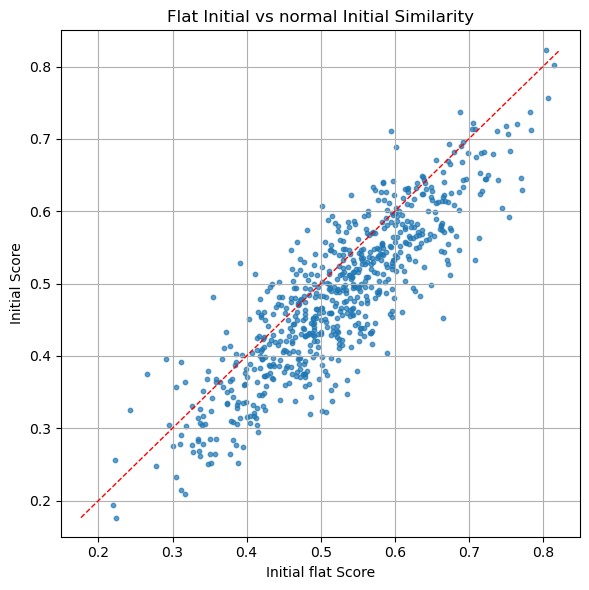

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
# 添加 x=y 的对角线
min_val = min(min(similarity_values), min(similarity_values_2))
max_val = max(max(similarity_values), max(similarity_values_2))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='x = y')
plt.scatter(similarity_values, similarity_values_2, s=10, alpha=0.7)
plt.xlim(0.15,0.85)
plt.ylim(0.15,0.85)
plt.xlabel("Initial flat Score")
plt.ylabel("Initial Score")
plt.title("Flat Initial vs normal Initial Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# 将 similarity 和 modified_atoms 打包成一个列表
paired = list(zip(similarity_values, modified_atoms))

# 按 similarity 值降序排序（从大到小）
paired_sorted = sorted(paired, key=lambda x: x[0], reverse=True)

# 解包排序后的列表
sorted_similarities, sorted_modified_atoms = zip(*paired_sorted)

# 查看第 N 名（例如第3名）
N = 676
print(f"第 {N} 名的 similarity 是 {sorted_similarities[N-1]:.4f}")
print(f"对应的 modified_atoms 是: {sorted_modified_atoms[N-1]}")


第 676 名的 similarity 是 0.1763
对应的 modified_atoms 是: [702]


In [5]:
# 设置参考结构目录
reference_dir = "data/CCl4"
output_dir = os.path.join(exp_dir, "post_analysis")

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# 加载参考结构
u1_ref, u2_ref, modified_atoms_ref, polar_axis_ref = load_structure_data(reference_dir)
ARPDF_ref = np.load(os.path.join(exp_dir, "ARPDF_ref.npy"))
with open(os.path.join(exp_dir, "metadata.json"), "r") as f:
    metadata = json.load(f)
xy_range = metadata["search_info"]["parameters"]["grids_range"]
N, M = metadata["search_info"]["parameters"]["grids_shape"]
X, Y = generate_grids(xy_range, N, M)

In [6]:
def get_ccl4_universe(universe, ccl4_mols):
    """
    Create a new universe containing only the selected CCl4 molecules
    """
    selected_atoms = universe.atoms[ccl4_mols]
    new_universe = mda.Merge(selected_atoms)
    new_universe.dimensions = universe.dimensions
    return new_universe

In [7]:
# Select the two CCl4 molecules by modified universe
ccl4_mols_ref = select_ccl4_molecules(u2_ref, 519)
# analyze the original structure of the selected CCl4 molecules
ccl4_universe_ref = get_ccl4_universe(u2_ref, ccl4_mols_ref)
ref_res = analyze_ccl4_structure(
    u2_ref, 519, selected_indices=ccl4_mols_ref
)
print(ref_res)

# rotate and save the reference structure
nbr_indices = select_nbr_mols(u2_ref, modified_atoms_ref, nbr_distance=5.0)
nbr_group = rotate_ccl4_molecules(u2_ref, ccl4_mols_ref, nbr_indices, polar_axis_ref)
nbr_group.write(os.path.join(output_dir, 'ref_nbr.gro'))

StructureAnalysisResult(dist_C_A_CL_A=4.01125705099132, dist_CL_A_CL_B=2.5467437263973456, dist_C_B_CL_B=2.2976081469040177, dist_C_A_C_B=8.343410008965357, theta_CL_A_CL_B=32.606152640005995, umbrella_angle=90.05439053739732, dists_CL_A_to_others=[4.425675208996655, 4.301730319861503, 4.396088054799225])


In [10]:
similarity_values_final : List[float] = []
for i, result in enumerate(results):
    u2_search = result.modified_universe
    optimize_box = "tmp/exp_experiment_no_filter_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"CCl4_optimized.gro"
    optimize_log = "tmp/exp_experiment_no_filter_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"log.txt"

    with open(optimize_log, 'r') as file:
        lines = file.readlines()

    # 获取最后一行并分割成列表
    last_line = lines[-1].strip().split(',')

    # 提取最后一行中的loss值
    loss_value = float(last_line[2])
    similarity_values_final.append(-loss_value)


In [15]:
similarity_values_final_2 : List[float] = []
for i, result in enumerate(results):
    u2_search = result.modified_universe
    optimize_box = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"CCl4_optimized.gro"
    optimize_log = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"log.txt"

    with open(optimize_log, 'r') as file:
        lines = file.readlines()

    # 获取最后一行并分割成列表
    last_line = lines[-1].strip().split(',')

    # 提取最后一行中的loss值
    loss_value = float(last_line[2])
    similarity_values_final_2.append(-loss_value)

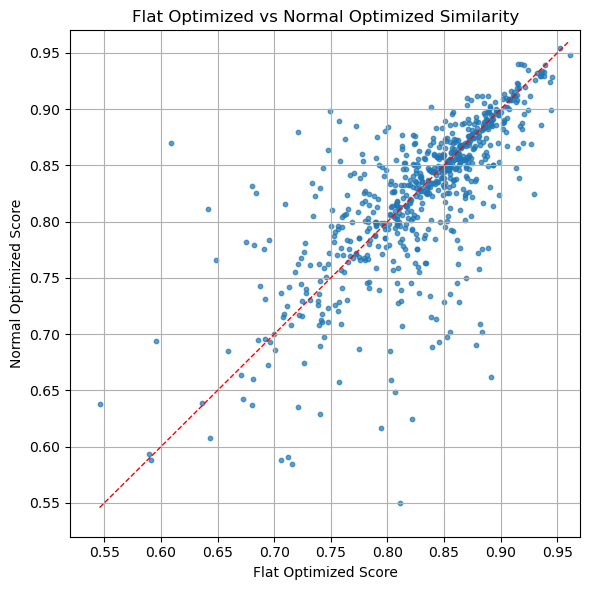

In [18]:
plt.figure(figsize=(6, 6))
# 添加 x=y 的对角线
min_val = min(min(similarity_values_final_2), min(similarity_values_final))
max_val = max(max(similarity_values_final_2), max(similarity_values_final))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='x = y')
plt.scatter(similarity_values_final, similarity_values_final_2, s=10, alpha=0.7)
plt.xlim(0.52,0.97)
plt.ylim(0.52,0.97)
plt.xlabel("Flat Optimized Score")
plt.ylabel("Normal Optimized Score")
plt.title("Flat Optimized vs Normal Optimized Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()

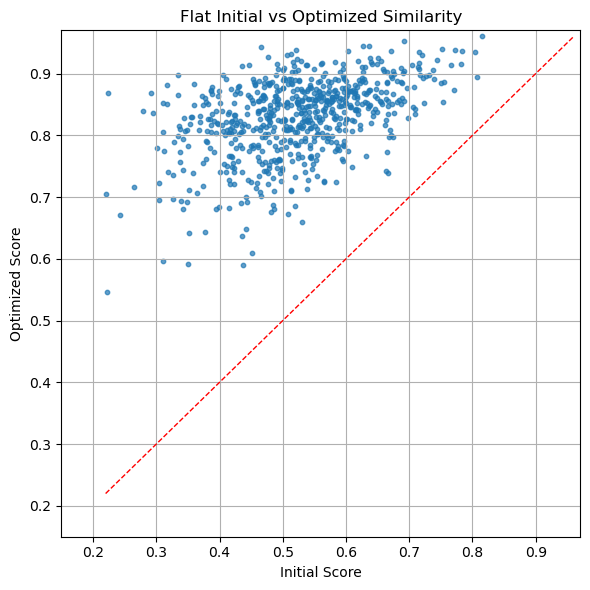

In [27]:
import matplotlib.pyplot as plt


plt.figure(figsize=(6, 6))
# 添加 x=y 的对角线
min_val = min(min(similarity_values), min(similarity_values_final))
max_val = max(max(similarity_values), max(similarity_values_final))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1, label='x = y')
plt.scatter(similarity_values, similarity_values_final, s=10, alpha=0.7)
plt.xlim(0.15,0.97)
plt.ylim(0.15,0.97)
plt.xlabel("Initial Score")
plt.ylabel("Optimized Score")
plt.title("Flat Initial vs Optimized Similarity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# 带索引排序，返回的是 (index, value)
indexed_sorted = sorted(enumerate(similarity_values_final), key=lambda x: x[1], reverse=True)

print("Top 20 similarity values with original indices:")
for i, (idx, val) in enumerate(indexed_sorted[:100], start=1):
    print(f"{i:2d}: Index {idx}, Value {val:.4f}")

Top 20 similarity values with original indices:
 1: Index 661, Value 0.8541
 2: Index 465, Value 0.8242
 3: Index 46, Value 0.8067
 4: Index 217, Value 0.7941
 5: Index 617, Value 0.7908
 6: Index 504, Value 0.7871
 7: Index 267, Value 0.7842
 8: Index 555, Value 0.7804
 9: Index 15, Value 0.7731
10: Index 61, Value 0.7728
11: Index 258, Value 0.7682
12: Index 435, Value 0.7625
13: Index 216, Value 0.7623
14: Index 63, Value 0.7613
15: Index 155, Value 0.7572
16: Index 244, Value 0.7557
17: Index 514, Value 0.7552
18: Index 336, Value 0.7460
19: Index 359, Value 0.7397
20: Index 189, Value 0.7351
21: Index 494, Value 0.7289
22: Index 552, Value 0.7272
23: Index 525, Value 0.7259
24: Index 268, Value 0.7224
25: Index 570, Value 0.7212
26: Index 81, Value 0.7169
27: Index 269, Value 0.7141
28: Index 369, Value 0.7125
29: Index 354, Value 0.7099
30: Index 324, Value 0.7093
31: Index 609, Value 0.7089
32: Index 591, Value 0.7085
33: Index 214, Value 0.7045
34: Index 384, Value 0.7032
35: I

In [ ]:
# 计算每个搜索结果的RMSD
rmsd_values: List[float] = []
similarity_values_final: List[float] = []
C_Cl: List[float] = []
Cl_Cl: List[float] = []
umbrella_angle: List[float] = []
theta: List[float] = []
for i, result in enumerate(results):
    # 获取搜索结果结构
    u2_search = result.modified_universe
    optimize_box = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"CCl4_optimized.gro"
    optimize_log = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"log.txt"

    # 获取搜索结果的CCl4分子
    ccl4_mols_search_list = select_nearest_ccl4_molecules(u2_search, result.molecule, n_neighbors=3)

    # 这次要记录最小RMSD对应的分子组
    min_rmsd = float('inf')
    best_ccl4_mols = None
    rmsd_candidates = []
    
    u1_ref_new = mda.Universe(optimize_box)
    for ccl4_mols_search in ccl4_mols_search_list:
        ccl4_universe_search = get_ccl4_universe(u1_ref_new, ccl4_mols_search)

        selection = [0, 1, 5, 6]  # 选定自己和邻居的C和Cl

        rmsd = calculate_rmsd(ccl4_universe_search, ccl4_universe_ref, selection=selection)
        rmsd_candidates.append(rmsd)

        if rmsd < min_rmsd:
            min_rmsd = rmsd
            best_ccl4_mols = ccl4_mols_search

        


    
    # 取最小值
    min_rmsd = min(rmsd_candidates)
    rmsd_values.append(min_rmsd)

    ccl4_mols_search = best_ccl4_mols
    
    analysis = analyze_ccl4_structure(
        u1_ref_new, 
        result.modified_atoms[0], 
        selected_indices=ccl4_mols_search
    )

    Cl_Cl.append(abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B))
    C_Cl.append(analysis.dist_C_A_CL_A)
    theta.append(analysis.theta_CL_A_CL_B)
    umbrella_angle.append(analysis.umbrella_angle)


    with open(optimize_log, 'r') as file:
        lines = file.readlines()

    # 获取最后一行并分割成列表
    last_line = lines[-1].strip().split(',')

    # 提取最后一行中的loss值
    loss_value = float(last_line[2])
    similarity_values_final.append(-loss_value)

    print(f"Result {i+1} RMSD: {rmsd:.3f} Å, similarity: {loss_value:.3f}")

In [ ]:
# 计算每个搜索结果的RMSD
#rmsd_values: List[float] = []
similarity_values_final: List[float] = []
C_Cl: List[float] = []
Cl_Cl: List[float] = []
max_C_Cl: List[float] = []
umbrella_angle: List[float] = []
theta: List[float] = []
Cl_Cl_dif: List[float] = []
Cl_other: List[float] = []
umbrella_angle_dif: List[float] = []
for i, result in enumerate(results):
    # 获取搜索结果结构
    u2_search = result.modified_universe
    optimize_box = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"CCl4_optimized.gro"
    optimize_log = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"log.txt"
    original_box = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+f"structure_{i}.gro"

    origin = mda.Universe(original_box)
    # 获取搜索结果的CCl4分子
    ccl4_mols_search_list = select_nearest_ccl4_molecules(u2_search, result.molecule, n_neighbors=3)

    
    u1_ref_new = mda.Universe(optimize_box)

    min_cl_cl = float('inf')
    min_c_cl = float('inf')
    max_c_cl = -float('inf')
    min_theta = float('inf')
    min_umbrella = float('inf')
    min_Cl_other = float('inf')
    best_ccl4_mols = None
    
    for ccl4_mols_search in ccl4_mols_search_list:
        ccl4_universe_search = get_ccl4_universe(u1_ref_new, ccl4_mols_search)

        selection = [0, 1, 5, 6]  # 选定自己和邻居的C和Cl

        analysis = analyze_ccl4_structure(
            u1_ref_new, 
            result.modified_atoms[0], 
            selected_indices=ccl4_mols_search
        )

        #print(analysis.dist_C_A_CL_A)

        if abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B) < min_cl_cl:
            min_cl_cl = abs(analysis.dist_CL_A_CL_B-ref_res.dist_CL_A_CL_B)
            best_ccl4_mols = ccl4_mols_search

        if abs(analysis.dist_C_A_CL_A-ref_res.dist_C_A_CL_A) < min_c_cl:
            min_c_cl = abs(analysis.dist_C_A_CL_A-ref_res.dist_C_A_CL_A)

        if analysis.dist_C_A_CL_A > max_c_cl:
            max_c_cl = analysis.dist_C_A_CL_A

        if abs(analysis.theta_CL_A_CL_B-ref_res.theta_CL_A_CL_B) < min_theta:
            min_theta = abs(analysis.theta_CL_A_CL_B-ref_res.theta_CL_A_CL_B)
            best_theta = ccl4_mols_search

        #print(analysis.umbrella_angle)
        #print(ref_res.umbrella_angle)
        #if (analysis.umbrella_angle>90):
        #    analysis.umbrella_angle=180-analysis.umbrella_angle
        #if abs(analysis.umbrella_angle-ref_res.umbrella_angle) < min_umbrella:
        #    min_umbrella = analysis.umbrella_angle

        
        min_Cl_other = min(abs(a - b) for a, b in zip(analysis.dists_CL_A_to_others, ref_res.dists_CL_A_to_others))


    analysis_2 = analyze_ccl4_structure(
            u1_ref_new, 
            result.modified_atoms[0], 
            selected_indices=best_ccl4_mols
        )
    #print(analysis_2.dist_CL_A_CL_B)

    analysis_3 = analyze_ccl4_structure(
            u1_ref_new, 
            result.modified_atoms[0], 
            selected_indices=best_theta
        )
    #analysis = analyze_ccl4_structure(
    #        u1_ref_new, 
    #        result.modified_atoms[0], 
    #        selected_indices=best_ccl4_mols
    #    )
    #print(analysis_2.dist_CL_A_CL_B)

    #print(analysis_2.umbrella_angle)

    #Cl_Cl_dif.append(analysis_2.dist_CL_A_CL_B-analysis.dist_CL_A_CL_B)
    #umbrella_angle_dif.append(analysis_2.umbrella_angle-analysis.umbrella_angle)




    Cl_Cl.append(analysis_2.dist_CL_A_CL_B)
    C_Cl.append(analysis_2.dist_C_A_CL_A)
    max_C_Cl.append(max_c_cl)
    theta.append(analysis_3.theta_CL_A_CL_B)
    umbrella_angle.append(analysis_2.umbrella_angle)
    Cl_other.append(np.max(analysis_2.dists_CL_A_to_others))


    with open(optimize_log, 'r') as file:
        lines = file.readlines()

    # 获取最后一行并分割成列表
    last_line = lines[-1].strip().split(',')

    # 提取最后一行中的loss值
    loss_value = float(last_line[2])
    similarity_values_final.append(-loss_value)


85.8527954102359
90.05439053739732
85.8527954102359
90.05439053739732
85.8527954102359
90.05439053739732
113.76237172523129
90.05439053739732
113.76237172523129
90.05439053739732
113.76237172523129
90.05439053739732
68.46643443315757
90.05439053739732
68.46643443315757
90.05439053739732
68.46643443315757
90.05439053739732
107.14260233768451
90.05439053739732
107.14260233768451
90.05439053739732
107.14260233768451
90.05439053739732
73.75617731067778
90.05439053739732
73.75617731067778
90.05439053739732
73.75617731067778
90.05439053739732
106.81673835847309
90.05439053739732
106.81673835847309
90.05439053739732
106.81673835847309
90.05439053739732
77.39493300267391
90.05439053739732
77.39493300267391
90.05439053739732
77.39493300267391
90.05439053739732
109.41543869746332
90.05439053739732
109.41543869746332
90.05439053739732
109.41543869746332
90.05439053739732
69.88688291033495
90.05439053739732
69.88688291033495
90.05439053739732
69.88688291033495
90.05439053739732
93.33225605669959
9

In [12]:
def compute_theta_stats(similarity_values, theta_values, threshold=0.9):
    """
    给定 similarity 和 theta 数组，计算 similarity 大于某阈值时的 theta 平均值与方差。
    
    参数：
        similarity_values (array-like): 相似度数组
        theta_values (array-like): theta 数组
        threshold (float): 相似度阈值，默认值为 0.9

    返回：
        tuple: (平均值, 方差, 满足条件的点数)
    """
    similarity_values = np.array(similarity_values)
    theta_values = np.array(theta_values)

    # 选出满足条件的 theta
    selected_theta = theta_values[similarity_values > threshold]

    # 计算均值和方差
    mean_theta = np.mean(selected_theta)
    var_theta = np.std(selected_theta)

    return mean_theta, var_theta, len(selected_theta)

In [ ]:
# 将RMSD值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, rmsd_values, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('RMSD (Å)')
plt.title('Relationship between Similarity and RMSD')

# 添加趋势线
z = np.polyfit(similarity_values_final, rmsd_values, 1)
p = np.poly1d(z)
plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_rmsd.png'))

plt.show()

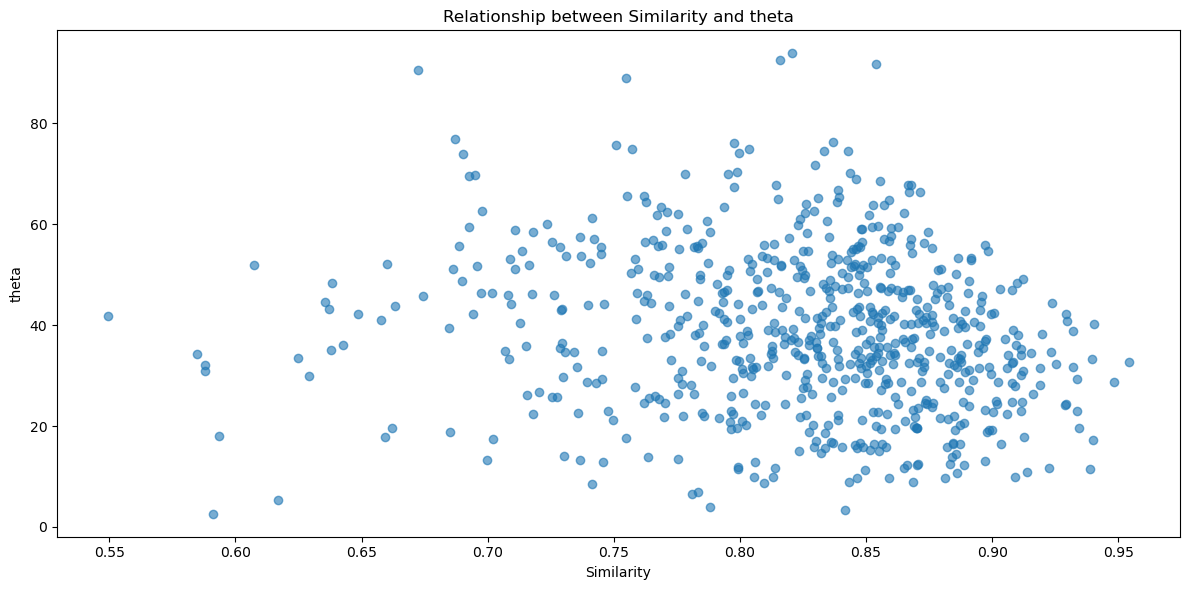

均值: 30.383971247917565
方差: 9.538653659339372
点数: 55


In [15]:
# 将theta值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, theta, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('theta')
plt.title('Relationship between Similarity and theta')

# 添加趋势线
z = np.polyfit(similarity_values_final, theta, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_theta.png'))

plt.show()
mean_theta, var_theta, count = compute_theta_stats(similarity_values_final, theta)
print("均值:", mean_theta)
print("方差:", var_theta)
print("点数:", count)

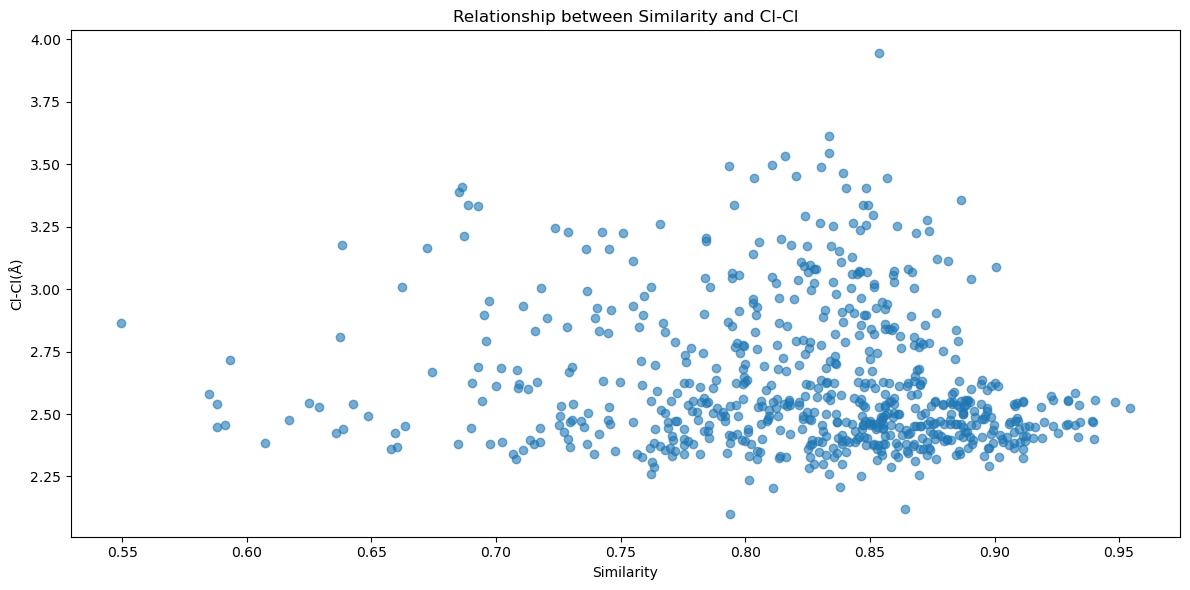

均值: 2.476427623405162
方差: 0.10971461848817016
点数: 55


In [18]:
# 将Cl-Cl值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, Cl_Cl, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('Cl-Cl(Å)')
plt.title('Relationship between Similarity and Cl-Cl')

# 添加趋势线
z = np.polyfit(similarity_values_final, Cl_Cl, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_ClCl.png'))

plt.show()
mean_theta, var_theta, count = compute_theta_stats(similarity_values_final, Cl_Cl)
print("均值:", mean_theta)
print("方差:", var_theta)
print("点数:", count)

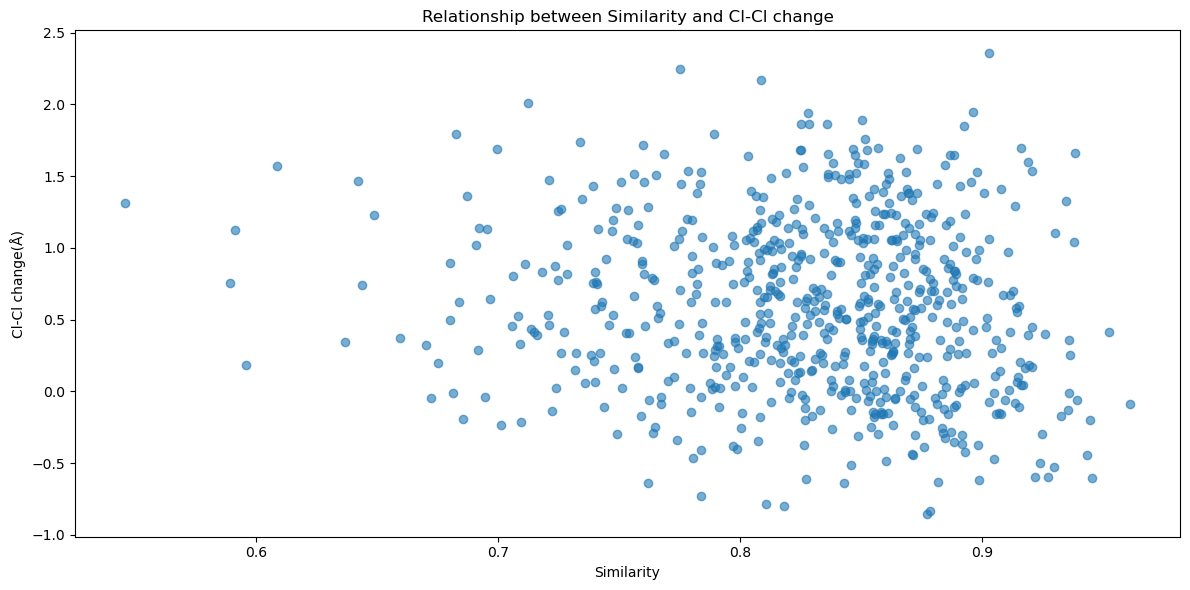

In [42]:
# 将Cl-Cl-diff值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, Cl_Cl_dif, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('Cl-Cl change(Å)')
plt.title('Relationship between Similarity and Cl-Cl change')

# 添加趋势线
z = np.polyfit(similarity_values_final, Cl_Cl_dif, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_ClCl_change.png'))

plt.show()

In [ ]:
similarity_values_final[313]

In [ ]:
# 带索引排序，返回的是 (index, value)
indexed_sorted = sorted(enumerate(similarity_values_final), key=lambda x: x[1], reverse=True)

print("Top 20 similarity values with original indices:")
for i, (idx, val) in enumerate(indexed_sorted[:100], start=1):
    print(f"{i:2d}: Index {idx}, Value {val:.4f}")



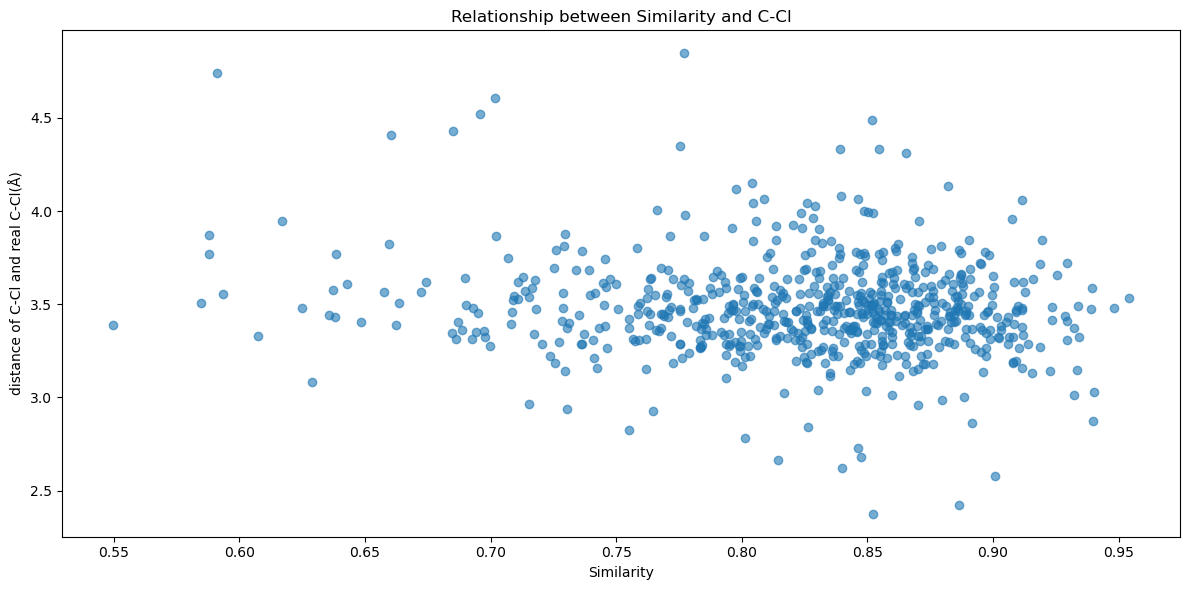

In [19]:
# 将C-Cl值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, C_Cl, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('distance of C-Cl and real C-Cl(Å)')
plt.title('Relationship between Similarity and C-Cl')

# 添加趋势线
z = np.polyfit(similarity_values_final, C_Cl, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_CCl.png'))

plt.show()

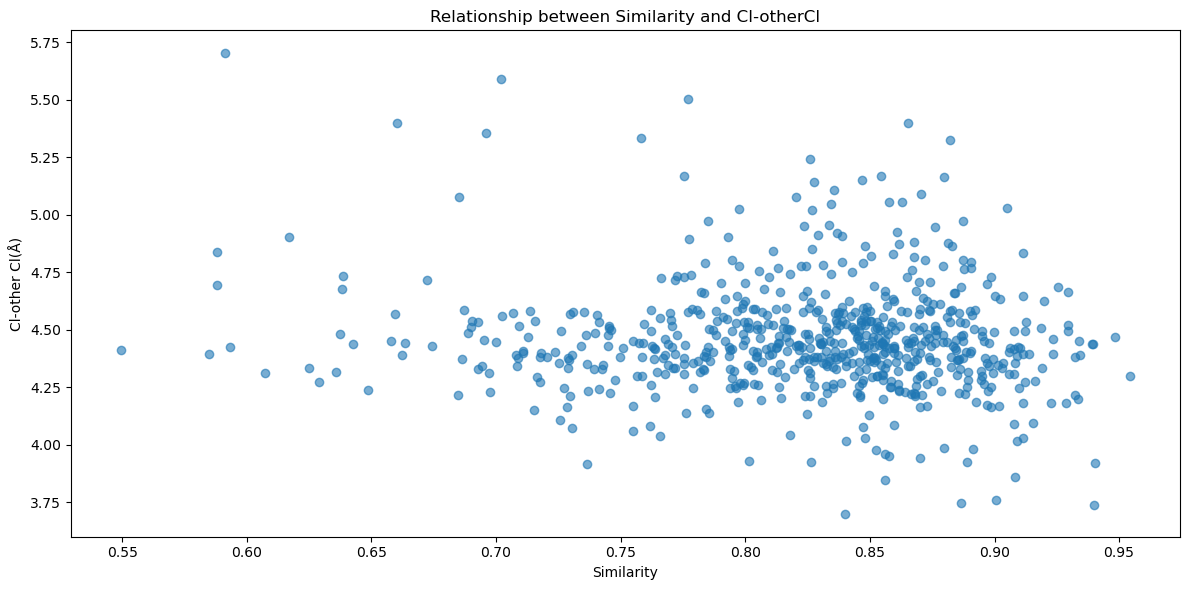

均值: 4.356646984032294
方差: 0.23964018713733534
点数: 55


In [25]:
# 将Cl-other值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, Cl_other, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('Cl-other Cl(Å)')
plt.title('Relationship between Similarity and Cl-otherCl')

# 添加趋势线
z = np.polyfit(similarity_values_final, Cl_other, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_Clother.png'))

plt.show()
mean_theta, var_theta, count = compute_theta_stats(similarity_values_final, Cl_other)
print("均值:", mean_theta)
print("方差:", var_theta)
print("点数:", count)

In [ ]:
# 将umbrella值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, umbrella_angle_dif, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('umbrella_change')
plt.title('Relationship between Similarity and umbrella')

# 添加趋势线
z = np.polyfit(similarity_values_final, umbrella_angle_dif, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_umbrellachange.png'))

plt.show()

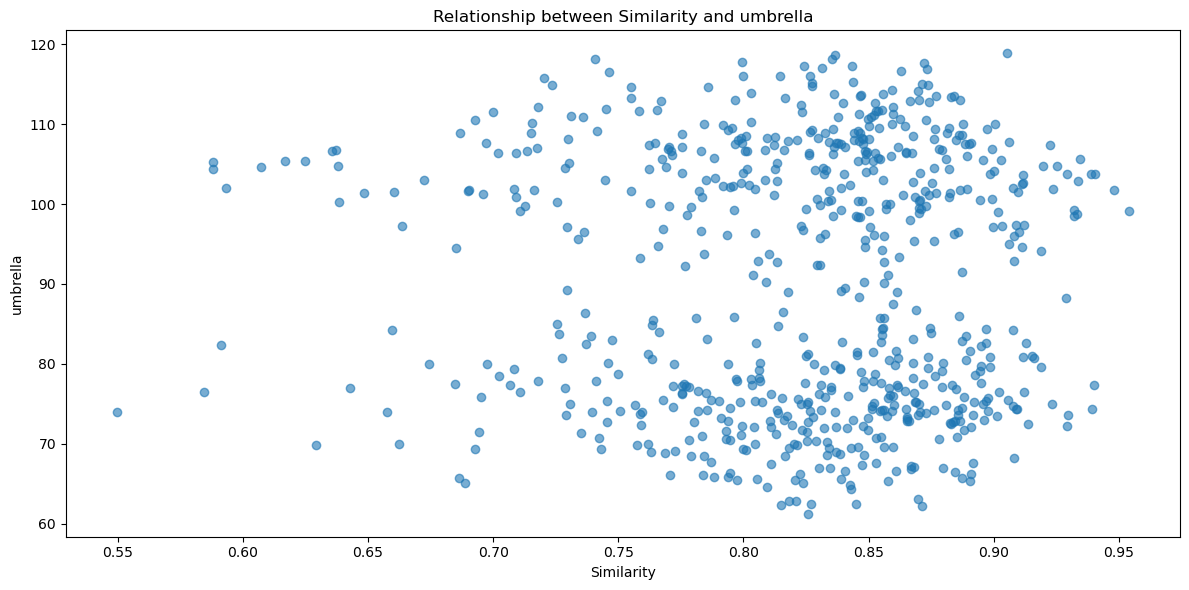

均值: 92.1903604850294
方差: 12.95269957591818
点数: 55


In [27]:
# 将umbrella值与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, umbrella_angle, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('umbrella')
plt.title('Relationship between Similarity and umbrella')

# 添加趋势线
z = np.polyfit(similarity_values_final, umbrella_angle, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_umbrellachange.png'))

plt.show()
mean_theta, var_theta, count = compute_theta_stats(similarity_values_final, umbrella_angle)
print("均值:", mean_theta)
print("方差:", var_theta)
print("点数:", count)

In [ ]:
plt.figure(figsize=(12, 6))
Cl_Cl = np.array(Cl_Cl)
C_Cl = np.array(C_Cl)
similarity_values_final = np.array(similarity_values_final)

mask_red = Cl_Cl > 0.3
mask_default = ~mask_red

# 画普通点（默认颜色）
plt.scatter(similarity_values_final[mask_default], C_Cl[mask_default], alpha=0.6, label='Cl_Cl ≤ 0.3')

# 画Cl_Cl > 0.3 的红点
plt.scatter(similarity_values_final[mask_red], C_Cl[mask_red], color='red', alpha=0.6, label='Cl_Cl > 0.3')

# 添加拟合线
z = np.polyfit(similarity_values_final, C_Cl, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.xlabel('Similarity')
plt.ylabel('C-Cl (Å)')
plt.title('Relationship between Similarity and C-Cl')
plt.legend()
plt.tight_layout()
#plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_CCl.png'))
plt.show()


In [ ]:
# 将umbrella-angle与相似度值进行比较
plt.figure(figsize=(12, 6))
plt.scatter(similarity_values_final, umbrella_angle, alpha=0.6)
plt.xlabel('Similarity')
plt.ylabel('umbrella angle')
plt.title('Relationship between Similarity and umbrella-angle')

# 添加趋势线
z = np.polyfit(similarity_values_final, umbrella_angle, 1)
p = np.poly1d(z)
#plt.plot(similarity_values_final, p(similarity_values_final), "r--", alpha=0.8)

plt.tight_layout()
plt.xlim(0.7,1)
plt.savefig(os.path.join(output_dir, 'similarity_vs_umbrella-angle.png'))

plt.show()

In [ ]:
print(len(Cl_Cl))
print(len(similarity_values_final))

In [ ]:
# Filter structures with similarity > 0.8 and RMSD > 1.0
filtered_structures = []

for i, (result, C_Cl_value) in enumerate(zip(results, C_Cl)):
    similarity = similarity_values_final[i]
    print(similarity)
    if (C_Cl_value > 0.5 and similarity > 0.90):
        print(1)
        # Get the search result structure
        u2_search = result.modified_universe
        optimize_box = "tmp/exp_angular_scale_3nm_cutoff_5/optimize/"+f"structure_{i}/"+"CCl4_optimized.gro"
        
        # ARPDF_search[ARPDF_search > 0] = 0
        fig = compare_ARPDF(result.ARPDF, ARPDF_ref, grids_XY=(X, Y), show_range=8.0)
        fig.savefig(os.path.join(output_dir, f'filtered_structure_{i}_C_Cl.png'))

        ccl4_mols_search_list = select_nearest_ccl4_molecules(u2_search, result.molecule, n_neighbors=3)

        # 这次要记录最小RMSD对应的分子组
        min_rmsd = float('inf')
        best_ccl4_mols = None
        rmsd_candidates = []
        
        u1_ref_new = mda.Universe(optimize_box)
        for ccl4_mols_search in ccl4_mols_search_list:
            ccl4_universe_search = get_ccl4_universe(u1_ref_new, ccl4_mols_search)

            selection = [0, 1, 5, 6]  # 选定自己和邻居的C和Cl

            rmsd = calculate_rmsd(ccl4_universe_search, ccl4_universe_ref, selection=selection)
            rmsd_candidates.append(rmsd)

            if rmsd < min_rmsd:
                min_rmsd = rmsd
                best_ccl4_mols = ccl4_mols_search


        ccl4_mols_search = best_ccl4_mols
        
        analysis = analyze_ccl4_structure(
            u1_ref_new, 
            result.modified_atoms[0], 
            selected_indices=ccl4_mols_search
        )


        # Save structure information
        filtered_structures.append({
            'index': i,
            'similarity': float(similarity),
            'Cl-Cl': float(C_Cl_value),
            'analysis': asdict(analysis),
            'structure_path': os.path.join(output_dir, f'filtered_structure_{i}_C_Cl.gro').replace("\\", "/")
        })
        
        # Save the structure file
        save_ccl4_result(result, os.path.join(output_dir, f'filtered_structure_{i}_C_Cl.gro'), nbr_distance=5.0)

# Save filtered results to JSON
if filtered_structures:
    with open(os.path.join(output_dir, 'filtered_structures.json'), 'w') as f:
        json.dump(filtered_structures, f, indent=4)

In [ ]:
# Filter structures with similarity > 0.8 and RMSD > 1.0
filtered_structures = []
similarity_values_final: List[float] = []
C_Cl: List[float] = []
Cl_Cl: List[float] = []
umbrella_angle: List[float] = []
for i, (result, rmsd) in enumerate(zip(results, rmsd_values)):
    similarity = result.similarity
    if (rmsd > 0.95 and similarity > 0.5):
        # Get the search result structure
        u2_search = result.modified_universe
        # ARPDF_search[ARPDF_search > 0] = 0
        fig = compare_ARPDF(result.ARPDF, ARPDF_ref, grids_XY=(X, Y), cos_sim=similarity, show_range=8.0)
        fig.savefig(os.path.join(output_dir, f'filtered_structure_{i}_low.png'))
        ccl4_mols_search = select_ccl4_molecules(u2_search, result.modified_atoms[0])
        
        # Analyze the structure
        analysis = analyze_ccl4_structure(
            u2_search,
            result.modified_atoms[0],
            selected_indices=ccl4_mols_search
        )
        



        # Save structure information
        filtered_structures.append({
            'index': i,
            'similarity': float(similarity),
            'rmsd': float(rmsd),
            'analysis': asdict(analysis),
            'structure_path': os.path.join(output_dir, f'filtered_structure_{i}_low.gro').replace("\\", "/")
        })
        
        # Save the structure file
        save_ccl4_result(result, os.path.join(output_dir, f'filtered_structure_{i}_low.gro'), nbr_distance=5.0)

# Save filtered results to JSON
if filtered_structures:
    with open(os.path.join(output_dir, 'filtered_structures.json'), 'w') as f:
        json.dump(filtered_structures, f, indent=4)

In [ ]:
pairs = list(zip(similarity_values_final, modified_atoms, rmsd_values))

# 排序取 top 10
top_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)[:10]

In [ ]:
# 拆分为两个列表
top_similarities = [x[0] for x in top_pairs]
top_atoms = [x[1] for x in top_pairs]
top_rmsd = [x[2] for x in top_pairs]

In [ ]:
labels = ['-'.join(map(str, group)) for group in top_atoms]

# 画图
plt.figure(figsize=(10, 5))
bars = plt.bar(range(len(top_similarities)), top_similarities, tick_label=labels)
plt.xlabel("Atom Groups")
plt.ylabel("Similarity")
plt.title("Similarity of Atom Groups")
plt.xticks(rotation=45)  # x轴文字旋转，防止重叠

# 添加数值标签
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,  # 上方略微留白
             f"{top_rmsd[i]:.2f}",  # 保留两位小数
             ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
for i, result in enumerate(results):
    if (result.molecule==313):
        u2_search = result.modified_universe
        optimize_box = "tmp/exp_opt_1D_avg/optimize/"+f"structure_{i}/"+f"CCl4_optimized.gro"
        ccl4_mols_search = select_ccl4_molecules(u2_search, result.molecule)
        u1_ref_new = mda.Universe(optimize_box)
        ccl4_universe_search = get_ccl4_universe(u1_ref, ccl4_mols_search)
        ccl4_universe_search.atoms.write('tmp/exp_opt_1D_avg/post_analysis/313_origin.gro')